## Load Data, Get Representation, Train Binary Classification RNN Model
(Binary classification on log fold change)

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

# reload(data_loading)
# reload(experiment)
# reload(rnn)
# reload(umap)

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 12ca5 vs MDM2

In [31]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is 0.9419173905476301


In [32]:
y_f_cutoff = 0.9419173905476301
y_p_cutoff = -0.4463856871323837

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [33]:
from sklearn import preprocessing
import pandas as pd

In [34]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [35]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [36]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [37]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [38]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [10]:
from sklearn.decomposition import PCA

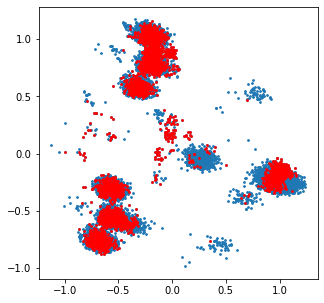

In [408]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [409]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.84677637219307 of the total variance


In [14]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

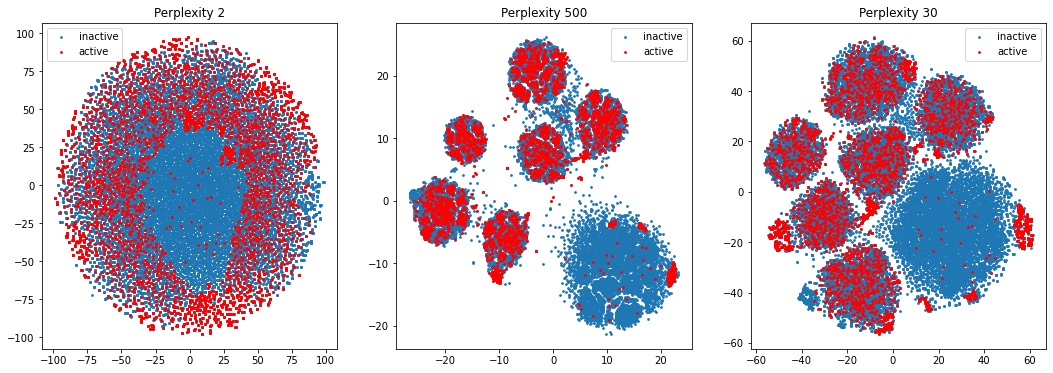

In [15]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [11]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [50]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', 'log_P_value'])

In [23]:
# import numpy as np
# from sklearn.datasets import make_multilabel_classification
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.linear_model import LogisticRegression

In [51]:
# kf = KFold(n_splits=10, shuffle=True)

# for train_index, test_index in kf.split(X):
#     X_train, y_train = np.array(X)[train_index],y[train_index]
    
#     clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)

#     X_test = np.array(X)[test_index]
    
#     # Append test 
#     pred = clf.predict(X_test) 
    
#     for i, index in enumerate(test_index):
#         df.loc[index, 'pred_class_F'] = pred[i][1]
#         df.loc[index, 'pred_class_P'] = pred[i][0]

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

In [55]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class_F == 1 and row.pred_class_P ==1:
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class_F == 1 and row.pred_class_P ==1:      
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [56]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

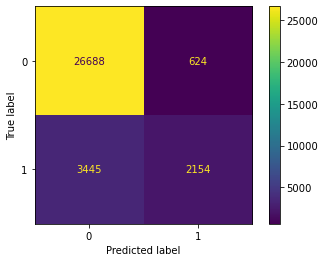

In [58]:
# cm = confusion_matrix(df.log_Fold, df.pred_class_F * df.pred_class_P )
# disp = ConfusionMatrixDisplay(confusion_matrix=cm)
# disp.plot()

In [17]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index],y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [18]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

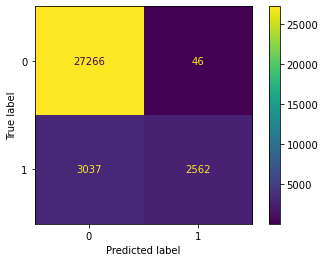

In [20]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

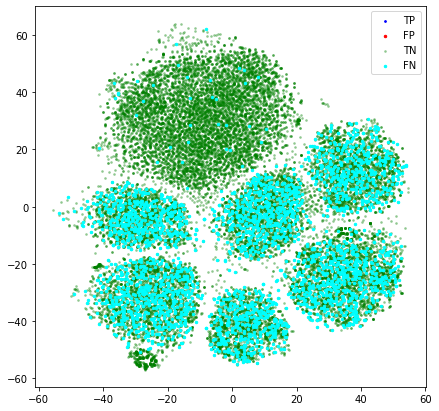

In [416]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')

ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [417]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

27264 48 3041 2558
accuracy 0.9061408039865091
precision 0.9815809669992326
recall 0.4568672977317378


In [418]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [419]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [420]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [421]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

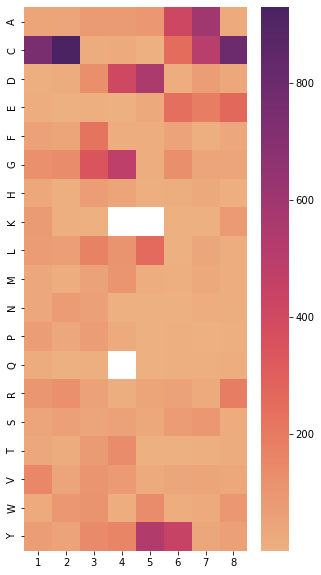

In [422]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [13]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [14]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50


2023-01-17 10:36:16.057927: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


206/206 [==============================] - 4s 5ms/step - loss: 0.5954 - accuracy: 0.9994 - recall: 0.2254 - precision: 0.5971
Epoch 2/50
206/206 [==============================] - 1s 5ms/step - loss: 0.5026 - accuracy: 0.9997 - recall: 0.5836 - precision: 0.6887
Epoch 3/50
206/206 [==============================] - 1s 5ms/step - loss: 0.4838 - accuracy: 0.9997 - recall: 0.6899 - precision: 0.6787
Epoch 4/50
206/206 [==============================] - 1s 5ms/step - loss: 0.4725 - accuracy: 0.9986 - recall: 0.7541 - precision: 0.6805
Epoch 5/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4650 - accuracy: 0.9979 - recall: 0.7710 - precision: 0.6792
Epoch 6/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4581 - accuracy: 0.9975 - recall: 0.7772 - precision: 0.6874
Epoch 7/50
206/206 [==============================] - 1s 5ms/step - loss: 0.4523 - accuracy: 0.9970 - recall: 0.7782 - precision: 0.6924
Epoch 8/50
206/206 [==============================] 

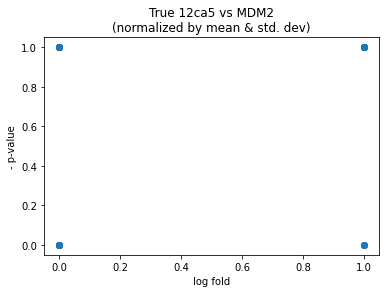

In [15]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [16]:
model =result.trained_model

In [17]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [18]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [19]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

21677 166 2387 2098
accuracy 0.9030309936189608
precision 0.926678445229682
recall 0.4677814938684504


In [20]:
embedding=umap.embedding_classification(model,X_train)

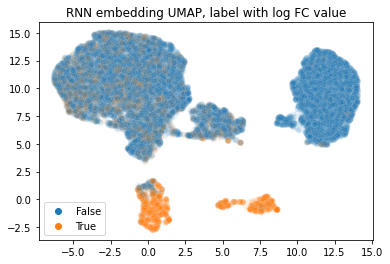

In [21]:
umap.UMAP_log_Fold(embedding, y_f_train)

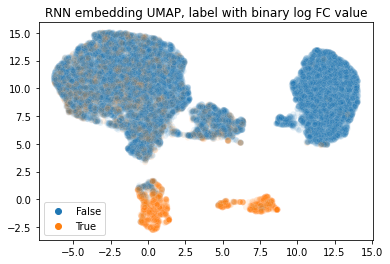

In [22]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

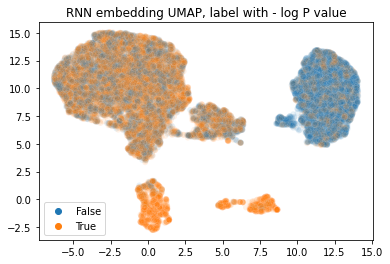

In [23]:
umap.UMAP_log_P(embedding, y_p_train)

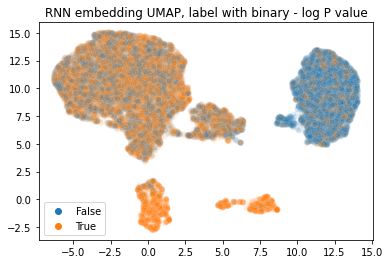

In [24]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

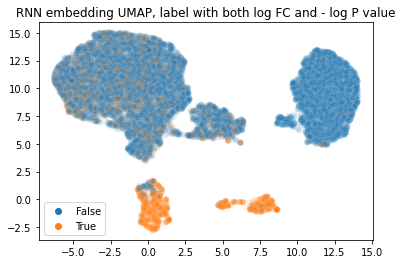

In [25]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [26]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [27]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_p_train[i]> 0.5:
            if x2<2.5 :
                good_seqs.append(X_seq[i])

In [28]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [29]:
ninemer_seq

['KCWVDYAC',
 'CTLLECRR',
 'TCRGDYAC',
 'GCSLLECK',
 'GWMTWCEE',
 'CGVYAACR',
 'PCGAYCLE',
 'VCTMLECR',
 'YCADLYDY',
 'CRFVDGCE',
 'RGGDYAAC',
 'CPGDYMVC',
 'EEFRDYAA',
 'CKGDYAAW',
 'RCLVDYAC',
 'EDFLDYAA',
 'RCLGDYGC',
 'EDMRYYAA',
 'SCYGDYAC',
 'CLFWDVVC',
 'RCPDYSAC',
 'EDLWDYAA',
 'CNGDYAAW',
 'CYGDYACS',
 'SCSLLECR',
 'KCVGDYSC',
 'PDRRDYAA',
 'FCHGDYAW',
 'CNHTWCEV',
 'CQGDYSAC',
 'DDFLDYAA',
 'KCWGYYAC',
 'DTVDYAAA',
 'CLGDYAQC',
 'HCGDYSAC',
 'HCVDYAAC',
 'RCLGYYAC',
 'WCYGDYAC',
 'EYLRYYAA',
 'LCLGDFGC',
 'DDLRYYAA',
 'CNGVYAAC',
 'CAADSRDY',
 'CYVDYAAC',
 'EDFLYYAA',
 'LCFGYYAC',
 'VCWGDYSC',
 'CGDYAEAC',
 'CRLFDGCD',
 'DYRDYSAA',
 'CRGEYAAC',
 'GCYGDYAG',
 'RDLADYAA',
 'YCFGDYSC',
 'HCLGDYAC',
 'YDLLYFAA',
 'CGDYAAMC',
 'CRLFDGCE',
 'CNFTWGEE',
 'CGDYAALC',
 'CAAARRVY',
 'GCPMLECK',
 'HCGDYAEC',
 'CFDYACWQ',
 'CRLVDGCV',
 'VCWDYSCW',
 'DTKDYSAA',
 'ACYGDYAC',
 'EVLLDFAA',
 'FCHWDYAC',
 'GCLGDSAR',
 'AWFGDYAC',
 'DDYSDYAA',
 'PCTLLEWR',
 'SCYGDFAC',
 'WRWYDGCE',
 'CVGDYACV',

In [30]:
import pandas as pd

In [31]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [32]:
seq9_s

1  2  3  4  5  6  7  8
0     K  C  W  V  D  Y  A  C
1     C  T  L  L  E  C  R  R
2     T  C  R  G  D  Y  A  C
3     G  C  S  L  L  E  C  K
4     G  W  M  T  W  C  E  E
...  .. .. .. .. .. .. .. ..
1370  W  G  D  Y  A  A  C  S
1371  D  S  R  D  Y  A  A  A
1372  E  D  L  R  Y  Y  A  A
1373  C  V  W  T  L  C  E  E
1374  F  C  G  A  Y  C  E  E

[1375 rows x 8 columns]

In [33]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [34]:
seq9_result

1    2    3    4      5    6    7    8
A   36   28   49   40   85.0  272  755  442
C  405  505   11   13    1.0  149  250  432
D  121  232  116  324  490.0   15   43   15
E  112    8    5    4   23.0  135  104  155
F   47   32  149   16   14.0  102    4   20
G   72   72  201  284   13.0   52   20   24
H   32    4   35   26    5.0    3    1    4
K   38   11   10    3    1.0    2    2   35
L   82   41  320  115  132.0    3   29    7
M   20   10   40   46   12.0    7   18    5
N   19   44   34    2    1.0    4    5    1
P   42   43   46   43    NaN    3    3    5
Q    9    8   10    3    1.0    1    2    9
R   59   72   41  139   28.0   25   13   98
S   30   47   24   29   33.0   96   53   13
T   24   22   45   72    2.0   11    3   10
V  140  100   66   54   36.0   25   27   18
W   17   47   64   15   64.0    9   16   46
Y   70   49  109  147  434.0  461   27   36

<AxesSubplot: >

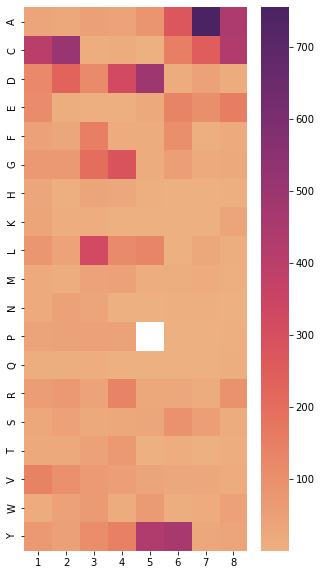

In [35]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [36]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('CLG', 94),
 ('PDY', 95),
 ('DLR', 102),
 ('ACR', 103),
 ('AVC', 105),
 ('LEC', 115),
 ('CGD', 117),
 ('AAC', 120),
 ('RDY', 122),
 ('LGD', 131),
 ('DYS', 155),
 ('YAC', 234),
 ('YAA', 362),
 ('GDY', 583),
 ('DYA', 716)]

In [37]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 716)
('GDY', 583)
('YAA', 362)
('YAC', 234)
('DYS', 155)


## MDM2 vs 12ca5

In [38]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "12ca5"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.4463856871323837, and log FC value cutoff is -0.9419173905476301


In [39]:
y_f_cutoff = -0.9419173905476301
y_p_cutoff = -0.4463856871323837

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [40]:
from sklearn import preprocessing
import pandas as pd

In [41]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [42]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [43]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [44]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [45]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [46]:
from sklearn.decomposition import PCA

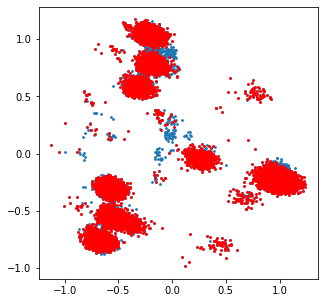

In [47]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [48]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.8469790333581882 of the total variance


In [56]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

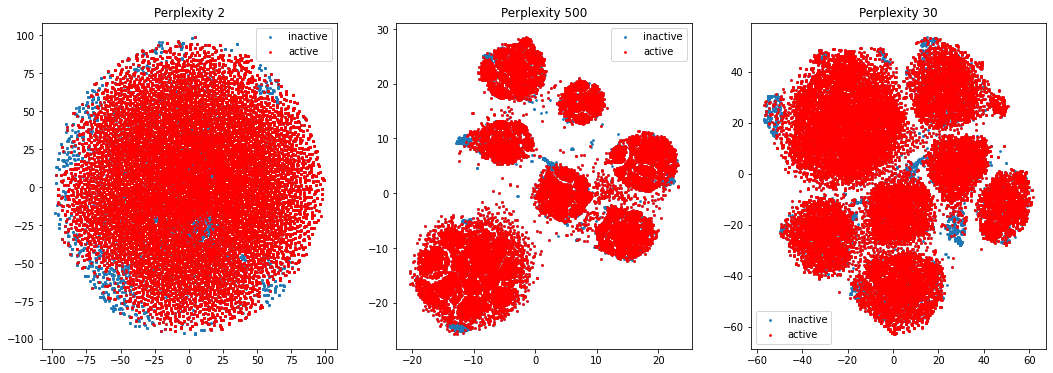

In [58]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [49]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [50]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', '-log_P_value'])

In [51]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index], y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [52]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

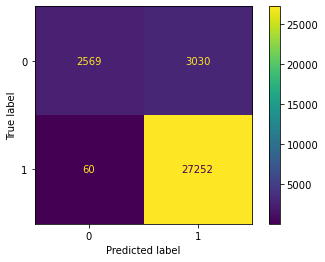

In [54]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

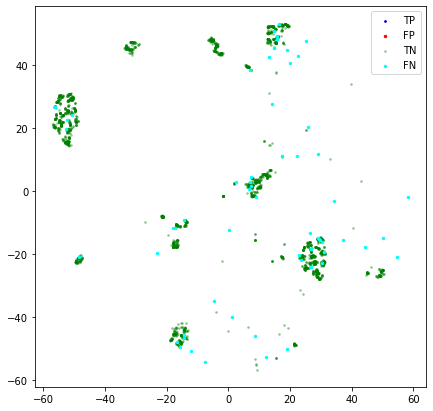

In [59]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')
ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [60]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

2569 3030 60 27252
accuracy 0.906110419008842
precision 0.8999405587477709
recall 0.9978031634446397


In [61]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [73]:
sum(df.label == 'TruePositive')

27252

In [62]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [63]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [64]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

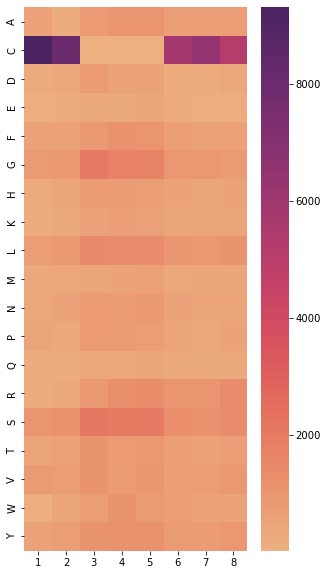

In [65]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [66]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [67]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
206/206 [==============================] - 5s 6ms/step - loss: 0.5072 - accuracy: 0.5087 - recall_1: 0.9313 - precision_1: 0.7669
Epoch 2/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4641 - accuracy: 0.5300 - recall_1: 0.9400 - precision_1: 0.7939
Epoch 3/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4498 - accuracy: 0.5294 - recall_1: 0.9429 - precision_1: 0.7990
Epoch 4/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4416 - accuracy: 0.5301 - recall_1: 0.9461 - precision_1: 0.8009
Epoch 5/50
206/206 [==============================] - 1s 5ms/step - loss: 0.4367 - accuracy: 0.5291 - recall_1: 0.9479 - precision_1: 0.8024
Epoch 6/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4334 - accuracy: 0.5297 - recall_1: 0.9498 - precision_1: 0.8037
Epoch 7/50
206/206 [==============================] - 1s 6ms/step - loss: 0.4302 - accuracy: 0.5303 - recall_1: 0.9508 - precision_1: 0.8049
Epoch 8/50
20

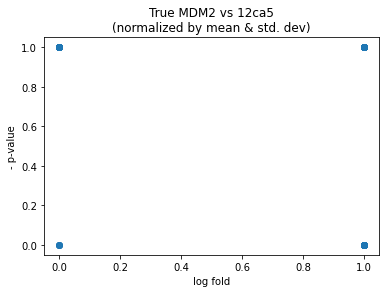

In [68]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [69]:
model =result.trained_model

In [70]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [71]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [72]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 2100 24228
accuracy 0.9202370100273473
precision 1.0
recall 0.9202370100273473


Text(0.5, 0, 'log_Fold')

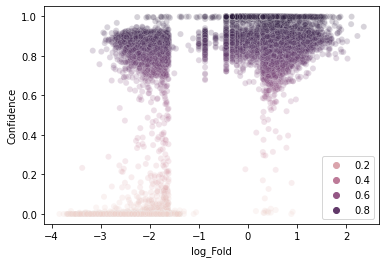

In [75]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train_orig, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [76]:
embedding=umap.embedding_classification(model,X_train)

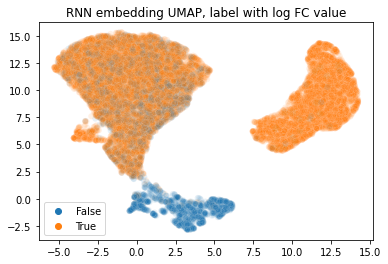

In [77]:
umap.UMAP_log_Fold(embedding, y_f_train)

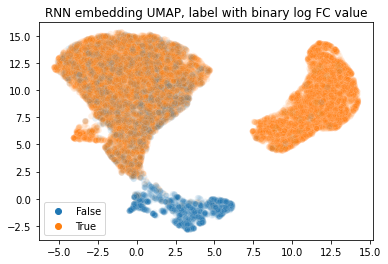

In [78]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

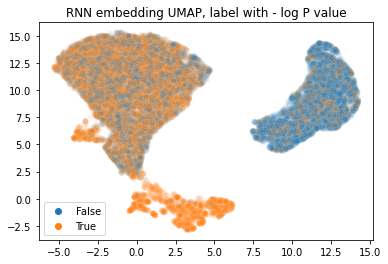

In [79]:
umap.UMAP_log_P(embedding, y_p_train)

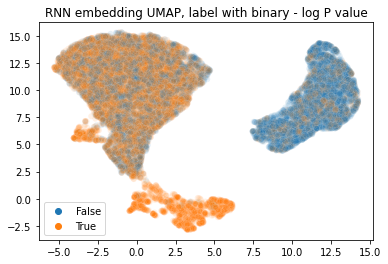

In [80]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

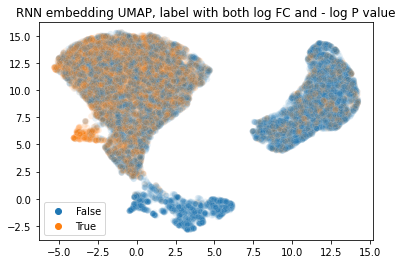

In [81]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [82]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [94]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_p_train[i]> 0.5:
            if x2<7.5 and x1<-2.5 :
                good_seqs.append(X_seq[i])

In [95]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [96]:
ninemer_seq

['CVDSFWCR',
 'FCDWYECY',
 'FSVWFWCS',
 'FCVWFWCA',
 'FCDWYWCS',
 'FCYFFWCS',
 'FCDWFGCN',
 'FCVWFWWS',
 'FCDRLWCS',
 'CSTFECWW',
 'FFDWFLCS',
 'YCDWFWCA',
 'FCDYKCMK',
 'FCDWYLCS',
 'FCDWLWCC',
 'FCYWYWCS',
 'ECMFWCVK',
 'YCDWFECN',
 'FCVWFECN',
 'YCYWFWCS',
 'LCGFWFCD',
 'FFYWFWCS',
 'FCDWFECH',
 'FCYWVLCS',
 'VCDWFECN',
 'FCDWFLCA',
 'FCVWSWCS',
 'FCDWLVCN',
 'LCDWFECN',
 'FCYWFLCS',
 'FCVLFWCC',
 'FCEWVWCS',
 'FCDWYCCS',
 'FCVWCWCA',
 'FCYLFWCD',
 'FCDWFKCN',
 'FCDCFECN',
 'FCDWYWCC',
 'FCDCFWCS',
 'FCVWFWCF',
 'FCVLFWCS',
 'CTCFECWW',
 'FCDCFWCC',
 'FCDGVWCS',
 'YCWDSRRC',
 'FCDCVWCS',
 'FCDLFYCK',
 'FCYWVWCS',
 'FCFDSWCY',
 'FCVWYWCS',
 'ECFSFSCW',
 'CESFACWW',
 'FCVRFWCS',
 'ECFDWYCK',
 'FCDFFWCS',
 'FCDCFLCS',
 'FCDWFCCA',
 'FFYLFWCS',
 'FSDWYWCS',
 'FCDWCLCS',
 'FRDWFWCS',
 'FFDWFECN',
 'FCDLFWCA',
 'FCDGFWCA',
 'FCVWFWFS',
 'CCDWCWCS',
 'FCDWFECS',
 'CVSFECFW',
 'FCVWYLCS',
 'FCGWFWCS',
 'CDWWWSHC',
 'LCVWFWCS',
 'FSDWFWCA',
 'FCDRFWCS',
 'CWSFECFW',
 'FCDWCWCA',
 'FCDWFRCS',

In [97]:
import pandas as pd

In [98]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [99]:
seq9_s

1  2  3  4  5  6  7  8
0    C  V  D  S  F  W  C  R
1    F  C  D  W  Y  E  C  Y
2    F  S  V  W  F  W  C  S
3    F  C  V  W  F  W  C  A
4    F  C  D  W  Y  W  C  S
..  .. .. .. .. .. .. .. ..
191  F  C  V  W  F  W  C  S
192  F  W  D  W  F  W  C  A
193  F  C  D  W  G  W  C  S
194  V  C  W  W  D  M  S  C
195  F  C  D  C  F  E  C  Y

[196 rows x 8 columns]

In [100]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [101]:
seq9_result

1      2      3      4      5      6      7     8
C   26.0  153.0    4.0   12.0    9.0   27.0  159.0  16.0
E    3.0    4.0    6.0    NaN   10.0   24.0    NaN   NaN
F  149.0   10.0    9.0   18.0  107.0    3.0   13.0   2.0
L    3.0    2.0    NaN   13.0   11.0   12.0    1.0   NaN
M    1.0    NaN    1.0    NaN    1.0    2.0    2.0   NaN
S    3.0    8.0    7.0    4.0    7.0    3.0    1.0  98.0
V    3.0    4.0   31.0    1.0   18.0    5.0    1.0   NaN
Y    8.0    2.0   18.0    1.0   14.0    2.0    1.0   7.0
A    NaN    2.0    5.0    1.0    2.0    1.0    NaN  17.0
D    NaN    3.0  103.0    6.0    2.0    NaN    NaN   4.0
N    NaN    1.0    NaN    NaN    NaN    NaN    NaN  22.0
R    NaN    2.0    1.0    3.0    1.0    7.0    5.0   2.0
T    NaN    1.0    3.0    NaN    NaN    NaN    NaN   2.0
W    NaN    4.0    6.0  133.0   11.0  106.0   11.0  14.0
G    NaN    NaN    2.0    4.0    2.0    2.0    NaN   1.0
K    NaN    NaN    NaN    NaN    1.0    1.0    1.0   6.0
Q    NaN    NaN    NaN    NaN    NaN    1.0    NaN   NaN
H    NaN    NaN    NaN    NaN    NaN    NaN    1.0   2.0
P    NaN    NaN    NaN    NaN    NaN    NaN    NaN   3.0

<AxesSubplot: >

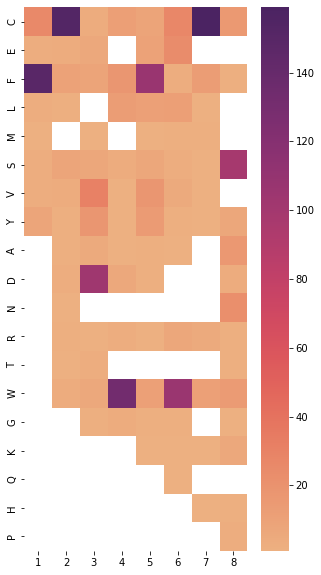

In [102]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [104]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('FCY', 16),
 ('CFW', 18),
 ('WVW', 18),
 ('WFE', 22),
 ('VWF', 23),
 ('FEC', 34),
 ('CVW', 34),
 ('FCV', 36),
 ('FWC', 57),
 ('WCS', 62),
 ('WFW', 65),
 ('DWF', 66),
 ('CDW', 92),
 ('FCD', 106),
 ('AFC', 184)]

In [105]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 184)
('FCD', 106)
('CDW', 92)
('DWF', 66)
('WFW', 65)


## MDM2 vs mCDH2

In [2]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "MDM2"
other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.08396512191297816, and log FC value cutoff is 0.04394247826022299


In [3]:
y_f_cutoff = 0.04394247826022299
y_p_cutoff = -0.08396512191297816

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [4]:
from sklearn import preprocessing
import pandas as pd

In [5]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [6]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [7]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [8]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [9]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [12]:
from sklearn.decomposition import PCA

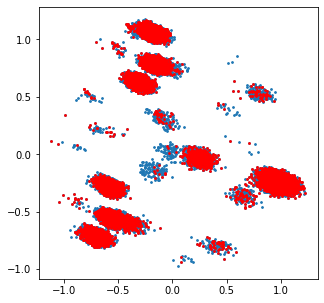

In [13]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [14]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.8458217116993526 of the total variance


In [15]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

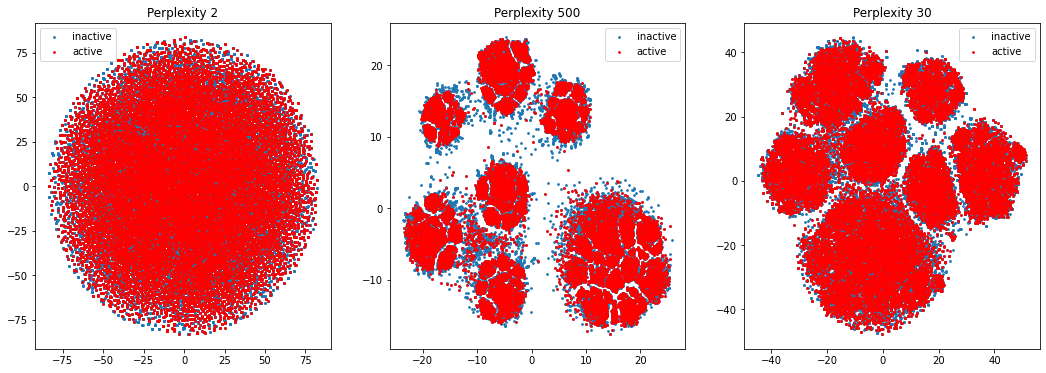

In [16]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [17]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [18]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', '-log_P_value'])

In [19]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index], y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [20]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

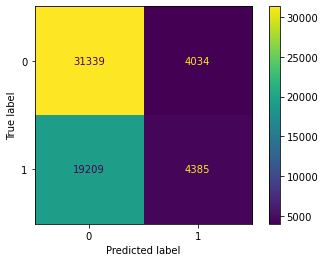

In [22]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

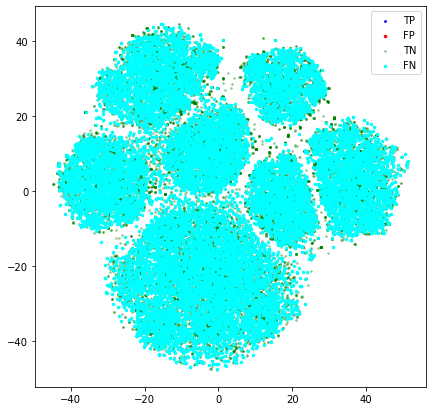

In [23]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')
ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [24]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

31339 4034 19209 4385
accuracy 0.6058303797039022
precision 0.5208457061408719
recall 0.18585233533949308


In [25]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [128]:
sum(df.label == 'TruePositive')

4318

In [129]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [130]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [131]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

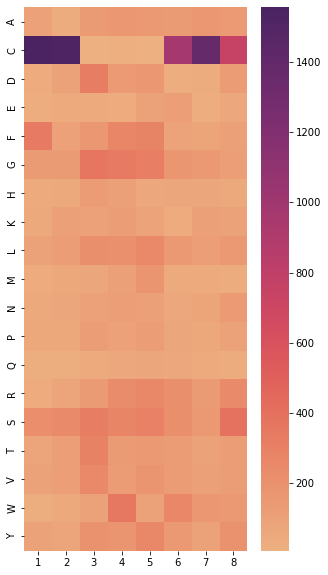

In [132]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [133]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [159]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/100
369/369 [==============================] - 5s 6ms/step - loss: 0.6335 - accuracy: 0.5202 - recall_3: 0.0246 - precision_3: 0.4827
Epoch 2/100
369/369 [==============================] - 2s 7ms/step - loss: 0.6136 - accuracy: 0.6508 - recall_3: 0.0791 - precision_3: 0.5314
Epoch 3/100
369/369 [==============================] - 2s 6ms/step - loss: 0.6131 - accuracy: 0.6456 - recall_3: 0.1245 - precision_3: 0.5324
Epoch 4/100
369/369 [==============================] - 2s 6ms/step - loss: 0.6126 - accuracy: 0.6354 - recall_3: 0.1484 - precision_3: 0.5306
Epoch 5/100
369/369 [==============================] - 2s 5ms/step - loss: 0.6119 - accuracy: 0.6300 - recall_3: 0.1709 - precision_3: 0.5318
Epoch 6/100
369/369 [==============================] - 2s 6ms/step - loss: 0.6114 - accuracy: 0.6227 - recall_3: 0.1797 - precision_3: 0.5297
Epoch 7/100
369/369 [==============================] - 2s 5ms/step - loss: 0.6111 - accuracy: 0.6161 - recall_3: 0.1836 - precision_3: 0.5312
Epoch 

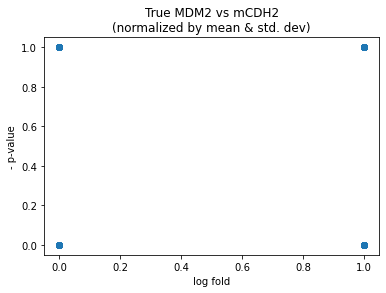

In [160]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [161]:
model =result.trained_model

In [162]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [163]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [164]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

23985 4348 13529 5311
accuracy 0.6210332181544528
precision 0.5498498809400559
recall 0.2819002123142251


Text(0.5, 0, 'log_Fold')

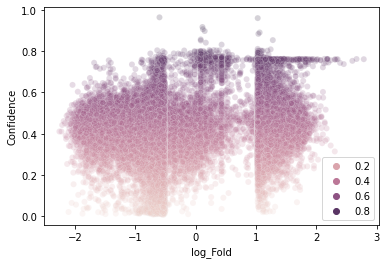

In [165]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train_orig, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [166]:
embedding=umap.embedding_classification(model,X_train)

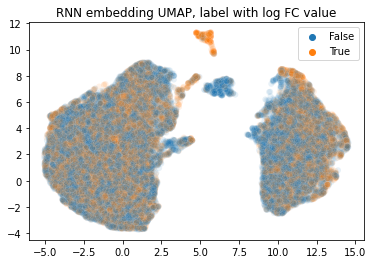

In [167]:
umap.UMAP_log_Fold(embedding, y_f_train)

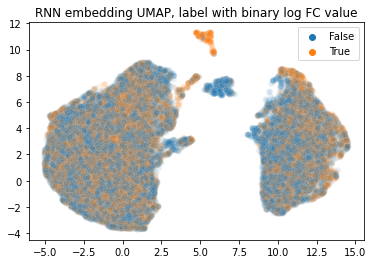

In [168]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

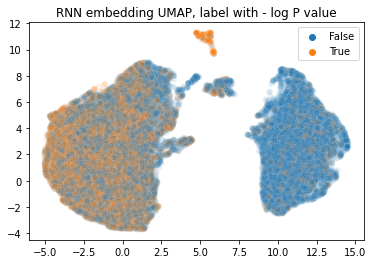

In [169]:
umap.UMAP_log_P(embedding, y_p_train)

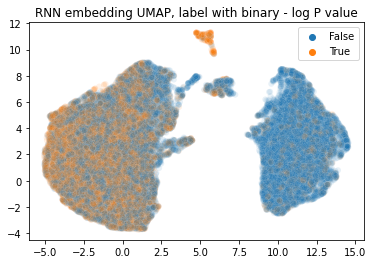

In [170]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

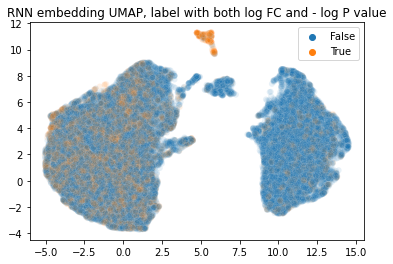

In [171]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [172]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [173]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if y_p_train[i]> 0.5:
            if x2>9 :
                good_seqs.append(X_seq[i])

In [174]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [175]:
ninemer_seq

['CDQARVGC',
 'FCDWYWCA',
 'FCDGLWCS',
 'FCVWFLCC',
 'FCDLLWCS',
 'FCEWLWCS',
 'CSTFECWW',
 'FGDWFWCS',
 'FWDWFWCA',
 'FCVWFWRS',
 'FCYFFWCS',
 'FCSWFWCS',
 'FCDWLWCA',
 'CYTFACFW',
 'YCVWFWCS',
 'FCYWFWCY',
 'FRDWFWCS',
 'FCDWFEYN',
 'FCDWFWCP',
 'FCYWFWCA',
 'CKTFMGWW',
 'FCDWVWGS',
 'FCDGFWCS',
 'CKSFMCWW',
 'FCVLFWCS',
 'FCAWFWCS',
 'CVSFSCWW',
 'FCDLFWCA',
 'FCEWFWCA',
 'FCVWLWCA',
 'FCFWLWCS',
 'FCDWFACN',
 'FCVWLECN',
 'FCVWFVCN',
 'LCVWVWCS',
 'CSSFECWW',
 'FCDCVWCS',
 'FCDWFDCN',
 'VCVWFWCS',
 'FCDWFWCA',
 'CMTFMCWW',
 'CKTFMCRW',
 'FCDWLWCS',
 'FCDLFWCY',
 'LCVWFWCS',
 'FCAWCWCS',
 'CKTFMCWL',
 'FCVWVWCC',
 'FCDWFCCS',
 'CMSFMWWW',
 'FFDWFCCS',
 'FCDWFLCY',
 'FCDWFHCS',
 'FCYWCWCS',
 'CTSFMCWW',
 'FCYCFLCS',
 'FCDLVWCS',
 'FCDWLLCS',
 'CKTFMWWW',
 'FCDWFWSS',
 'FCDRFWCA',
 'CSGWLWRA',
 'CKTFMYWW',
 'CSSFECFW',
 'YCVWVWCS',
 'FCVWVWCS',
 'FCVWLLCS',
 'FCDWVGCS',
 'FWDWVWCS',
 'FCDWFWCT',
 'FCDWCLCS',
 'CTCFECWW',
 'FCVWFWGS',
 'VCDWFWRS',
 'CSSFVCFW',
 'FCVWFWFS',
 'FCDWYLCS',

In [176]:
import pandas as pd

In [177]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [178]:
seq9_s

1  2  3  4  5  6  7  8
0    C  D  Q  A  R  V  G  C
1    F  C  D  W  Y  W  C  A
2    F  C  D  G  L  W  C  S
3    F  C  V  W  F  L  C  C
4    F  C  D  L  L  W  C  S
..  .. .. .. .. .. .. .. ..
200  C  M  W  T  W  C  F  E
201  C  K  T  F  L  C  W  W
202  F  C  D  W  G  W  C  S
203  F  F  D  W  F  L  C  S
204  F  C  D  W  F  W  C  C

[205 rows x 8 columns]

In [179]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [180]:
seq9_result

1      2     3      4     5      6      7     8
C   52.0  140.0   3.0    4.0   7.0   46.0  140.0  13.0
D    1.0    3.0  91.0    NaN   NaN    1.0    NaN   2.0
F  137.0    5.0   7.0   45.0  97.0    2.0   14.0   2.0
L    2.0    NaN   NaN   10.0  24.0   16.0    2.0   2.0
R    1.0    1.0   NaN    5.0   4.0    2.0    4.0   1.0
S    1.0   12.0  14.0    1.0   4.0    1.0    2.0  92.0
V    2.0    2.0  34.0    NaN  21.0    5.0    NaN   NaN
W    1.0    7.0   2.0  132.0   3.0  107.0   35.0  41.0
Y    8.0    2.0  12.0    NaN   7.0    1.0    3.0   7.0
E    NaN    3.0   5.0    NaN  11.0   16.0    NaN   1.0
G    NaN    1.0   2.0    4.0   2.0    4.0    3.0   NaN
K    NaN   15.0   NaN    NaN   NaN    1.0    1.0   NaN
M    NaN    8.0   NaN    NaN  21.0    NaN    NaN   NaN
N    NaN    2.0   NaN    NaN   1.0    NaN    NaN  22.0
Q    NaN    1.0   1.0    NaN   NaN    NaN    NaN   1.0
T    NaN    3.0  28.0    1.0   NaN    1.0    NaN   2.0
A    NaN    NaN   5.0    3.0   3.0    1.0    1.0  16.0
H    NaN    NaN   1.0    NaN   NaN    1.0    NaN   NaN
P    NaN    NaN   NaN    NaN   NaN    NaN    NaN   3.0

<AxesSubplot: >

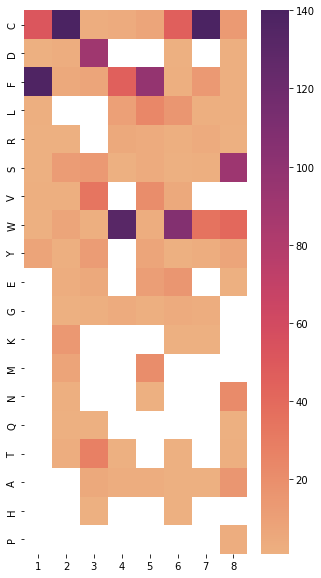

In [181]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [182]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('TFM', 23),
 ('WVW', 23),
 ('CWW', 24),
 ('ACK', 25),
 ('FEC', 26),
 ('FMC', 31),
 ('FCV', 39),
 ('CVW', 39),
 ('FWC', 50),
 ('WCS', 63),
 ('WFW', 63),
 ('DWF', 69),
 ('CDW', 93),
 ('FCD', 101),
 ('AFC', 182)]

In [183]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AFC', 182)
('FCD', 101)
('CDW', 93)
('DWF', 69)
('WFW', 63)


## mCDH2 vs MDM2

In [26]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "mCDH2"
other_protein = "MDM2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.08396512191297816, and log FC value cutoff is -0.04394247826022299


In [27]:
y_f_cutoff = -0.04394247826022299
y_p_cutoff = -0.08396512191297816

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [28]:
from sklearn import preprocessing
import pandas as pd

In [29]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [30]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [31]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [32]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [33]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [34]:
from sklearn.decomposition import PCA

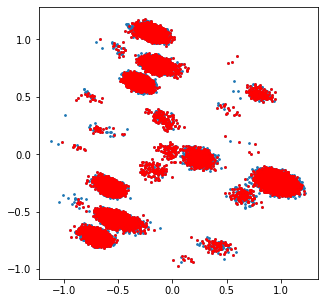

In [35]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [36]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.8458412316203758 of the total variance


In [37]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

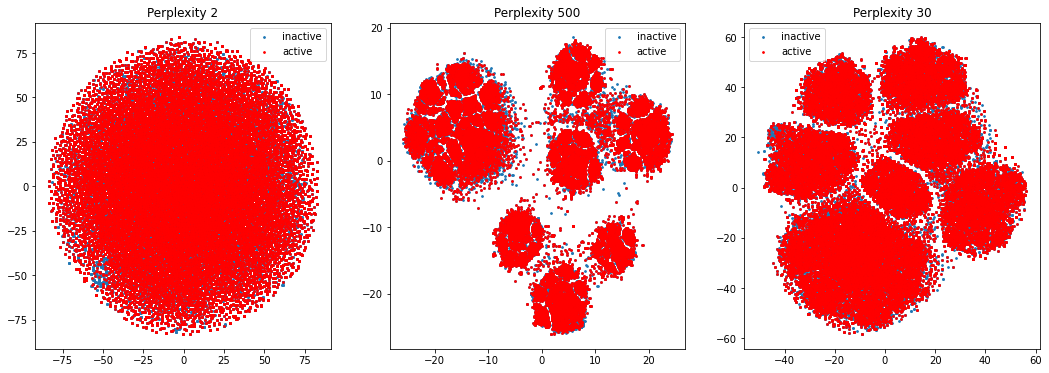

In [38]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [39]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [40]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', '-log_P_value'])

In [41]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index], y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [42]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

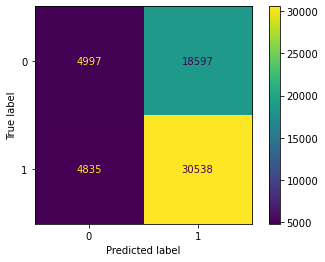

In [44]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

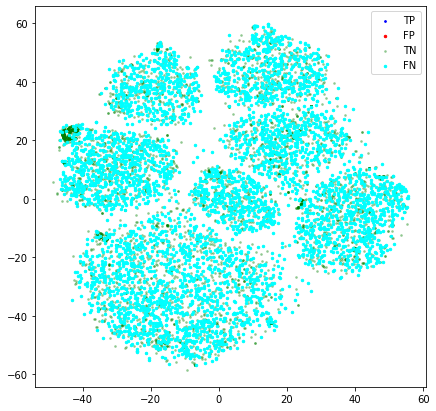

In [45]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')
ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [46]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

4997 18597 4835 30538
accuracy 0.6026251971441654
precision 0.6215121603744784
recall 0.8633138269301445


In [203]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [204]:
sum(df.label == 'TruePositive')

30645

In [205]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [206]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [207]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

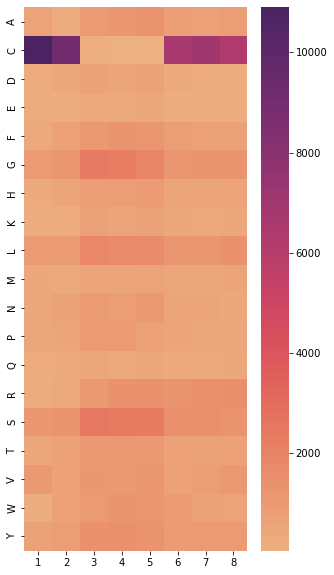

In [208]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [209]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [210]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
369/369 [==============================] - 6s 6ms/step - loss: 0.6278 - accuracy: 0.4582 - recall_4: 0.7088 - precision_4: 0.5875
Epoch 2/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6144 - accuracy: 0.4581 - recall_4: 0.7462 - precision_4: 0.5874
Epoch 3/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6136 - accuracy: 0.4583 - recall_4: 0.7649 - precision_4: 0.5849
Epoch 4/50
369/369 [==============================] - 2s 5ms/step - loss: 0.6127 - accuracy: 0.4587 - recall_4: 0.7689 - precision_4: 0.5859
Epoch 5/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6123 - accuracy: 0.4604 - recall_4: 0.7788 - precision_4: 0.5848
Epoch 6/50
369/369 [==============================] - 2s 6ms/step - loss: 0.6120 - accuracy: 0.4644 - recall_4: 0.7674 - precision_4: 0.5865
Epoch 7/50
369/369 [==============================] - 2s 5ms/step - loss: 0.6112 - accuracy: 0.4693 - recall_4: 0.7609 - precision_4: 0.5887
Epoch 8/50
36

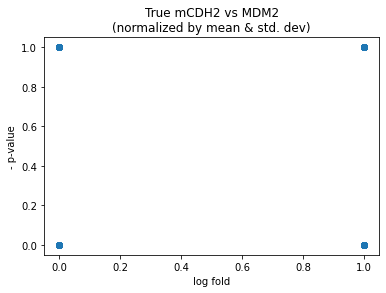

In [211]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [212]:
model =result.trained_model

In [213]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [214]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [215]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 1635 45538
accuracy 0.9653403429928137
precision 1.0
recall 0.9653403429928137


Text(0.5, 0, 'log_Fold')

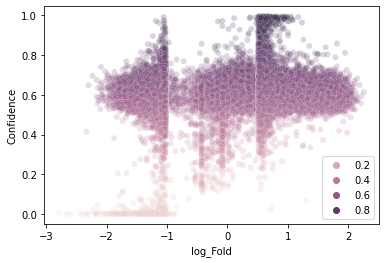

In [216]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train_orig, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [217]:
embedding=umap.embedding_classification(model,X_train)

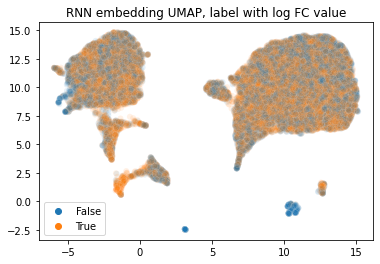

In [218]:
umap.UMAP_log_Fold(embedding, y_f_train)

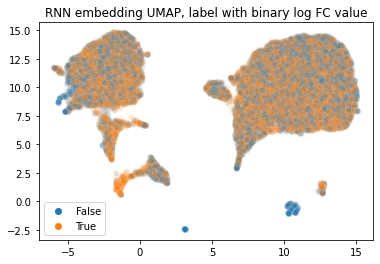

In [219]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

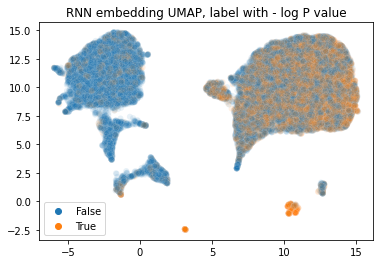

In [220]:
umap.UMAP_log_P(embedding, y_p_train)

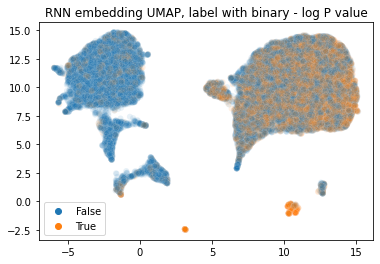

In [221]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

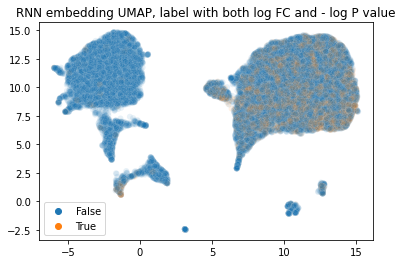

In [222]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [223]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [224]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if x1<1 and x2<3 :
            good_seqs.append(X_seq[i])

In [225]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [226]:
ninemer_seq

['CTSKRRYY',
 'CPGATWGM',
 'CLVVSFGE',
 'GCTSRWWG',
 'VYGPSCAA',
 'DWGGTWCM',
 'ACRVGRSS',
 'VGPTDCRK',
 'YQSWAYAA',
 'CNYPGWGG',
 'FFVGGGCG',
 'VGALVECR',
 'AMDLLRAA',
 'MWQGACAW',
 'CSLESWRL',
 'PHRFNGAA',
 'WGGGNCWQ',
 'CSTAKWGW',
 'VCTYAWRD',
 'TCGAGGGG',
 'CSNVGRGG',
 'GWVRHLCG',
 'FPWERPAA',
 'CTYPGGGA',
 'RGESTDLC',
 'ASWRGAAA',
 'CSGGSTRW',
 'RGDLAYCP',
 'AWLPRCSL',
 'GCWGGGGR',
 'DCEPGKWG',
 'ACVKYLGG',
 'CHYWGGWG',
 'SGSTFWCT',
 'WHWKTRCD',
 'WCSAAEAA',
 'LRTSAAAA',
 'ACLFERWR',
 'CLVVSGGE',
 'CNALWRPA',
 'YCSVRLAA',
 'SRTGSFGL',
 'CKPMTKAA',
 'SCPVMWGG',
 'CQSTYWPA',
 'AWLFERWG',
 'QSTTWFCS',
 'WLGNSSRC',
 'CQSFLRSR',
 'WQSLSVPC',
 'FSHLGSAA',
 'GGGGNCWQ',
 'GLVVSCGE',
 'GWDSFTCL',
 'YCHAGGRG',
 'LFTTLLAA',
 'WRSESCYH',
 'RTHRLVGR',
 'ACTRVGGG',
 'CLVVSWGE',
 'SWGPRNFC',
 'PCPAGGRW',
 'MTRGQTAA',
 'FCGKYWGR',
 'CPLLWGSM',
 'RCESTDLW',
 'CLVGLERG',
 'DYCYRNAA',
 'GWARNVTC',
 'LDRHSAAA',
 'CQSTYWQA',
 'SCFTRNAA',
 'LSYSWQAA',
 'AGTRVGCG',
 'ACASWYGW',
 'TWGDGGCG',
 'WLVVSCGE',

In [227]:
import pandas as pd

In [228]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [229]:
seq9_s

1  2  3  4  5  6  7  8
0    C  T  S  K  R  R  Y  Y
1    C  P  G  A  T  W  G  M
2    C  L  V  V  S  F  G  E
3    G  C  T  S  R  W  W  G
4    V  Y  G  P  S  C  A  A
..  .. .. .. .. .. .. .. ..
468  R  P  F  L  H  C  S  Q
469  S  G  L  P  F  W  A  A
470  Y  A  H  H  W  G  A  A
471  Y  C  H  S  G  W  R  G
472  Q  C  F  S  A  W  G  K

[473 rows x 8 columns]

In [230]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [231]:
seq9_result

1   2   3   4   5   6    7    8
A   34   8  18  36  35  19  124  120
C  120  95   4   1   2  54   66   35
D    6  11  11   8  17   3    2    3
E    4   2  12   9  15   8    1    7
F   28  21  20  28  19  18    5   15
G   52  73  71  74  92  64   64   92
H    9  16  17  11  13  16    7    6
K    3   2  14  16  10   6    1    7
L   42  36  45  40  37  21   22   28
M    6   7  11   5  13   7    2    9
N    3  10  18  22  18  11    1    6
P   11  15  27  32  21  17    5    8
Q    5  12   8   6   4   5    7    9
R   16  23  27  37  38  65   72   45
S   37  38  45  40  48  30   19   17
T   18  19  31  21  22  11    6    8
V   30   9  46  35  19  13   12   20
W   32  65  19  30  28  93   48   29
Y   17  11  29  22  22  12    9    9

<AxesSubplot: >

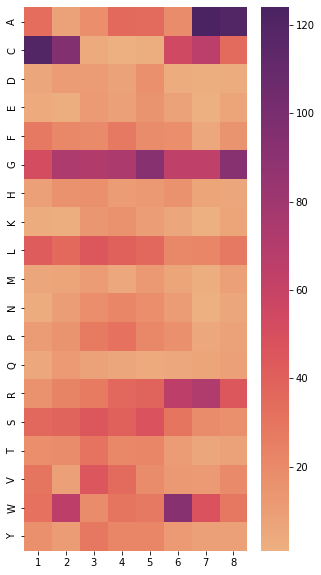

In [232]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [233]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('RAA', 17),
 ('ALC', 17),
 ('LWG', 17),
 ('SAA', 18),
 ('GGL', 18),
 ('AYC', 18),
 ('ACT', 19),
 ('AGW', 20),
 ('AAA', 22),
 ('ACG', 29),
 ('ACL', 29),
 ('ACS', 29),
 ('WGG', 30),
 ('GGG', 36),
 ('AGG', 37)]

In [234]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('AGG', 37)
('GGG', 36)
('WGG', 30)
('ACS', 29)
('ACL', 29)


## 12ca5 vs mCDH2

In [47]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "12ca5"
other_protein = "mCDH2"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.33058129229327954, and log FC value cutoff is 0.955421147441985


In [48]:
y_f_cutoff =  0.955421147441985
y_p_cutoff = -0.33058129229327954

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [49]:
from sklearn import preprocessing
import pandas as pd

In [50]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [51]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [52]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [53]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [54]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [55]:
from sklearn.decomposition import PCA

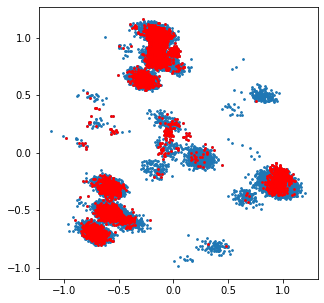

In [56]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [57]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.8443805671760377 of the total variance


In [58]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

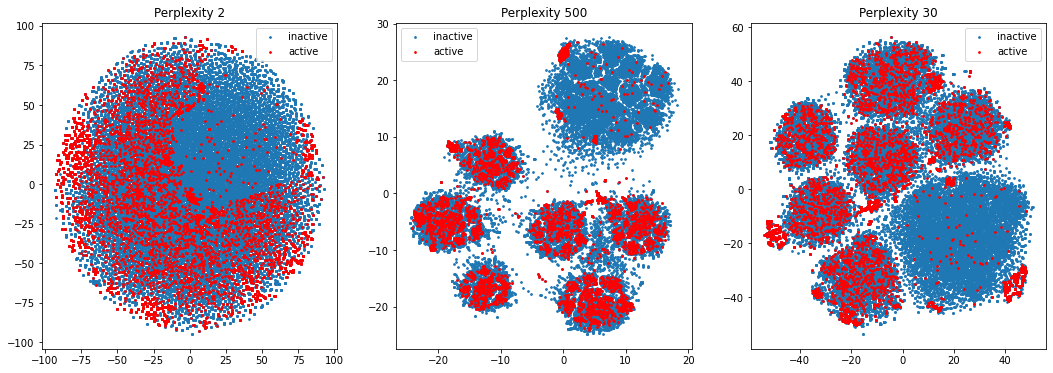

In [59]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [60]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [61]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', '-log_P_value'])

In [62]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index], y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [63]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

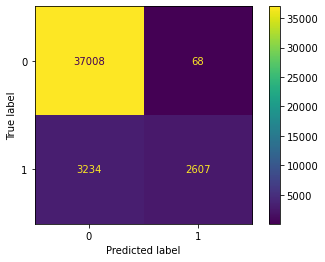

In [65]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

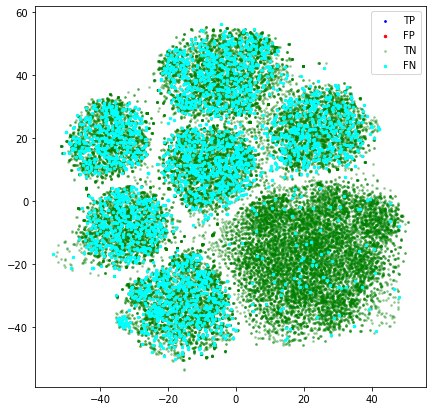

In [66]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')
ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [67]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

37008 68 3234 2607
accuracy 0.9230607917608407
precision 0.9745794392523365
recall 0.4463276836158192


In [68]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [253]:
sum(df.label == 'TruePositive')

2603

In [254]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [255]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [256]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

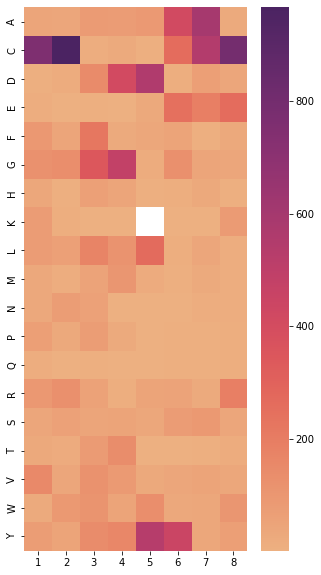

In [257]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [258]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [259]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
269/269 [==============================] - 6s 6ms/step - loss: 0.4815 - accuracy: 0.7061 - recall_5: 0.1093 - precision_5: 0.4859
Epoch 2/50
269/269 [==============================] - 2s 6ms/step - loss: 0.4195 - accuracy: 0.9461 - recall_5: 0.1767 - precision_5: 0.6524
Epoch 3/50
269/269 [==============================] - 1s 5ms/step - loss: 0.4008 - accuracy: 0.9468 - recall_5: 0.2103 - precision_5: 0.7950
Epoch 4/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3918 - accuracy: 0.9454 - recall_5: 0.2164 - precision_5: 0.8155
Epoch 5/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3884 - accuracy: 0.9433 - recall_5: 0.2159 - precision_5: 0.8280
Epoch 6/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3855 - accuracy: 0.9454 - recall_5: 0.2181 - precision_5: 0.8468
Epoch 7/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3832 - accuracy: 0.9422 - recall_5: 0.2154 - precision_5: 0.8633
Epoch 8/50
26

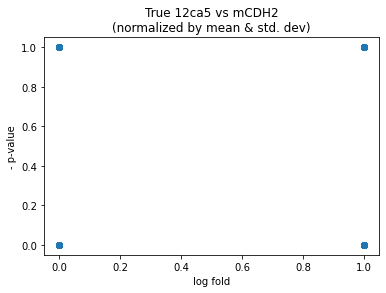

In [260]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [261]:
model =result.trained_model

In [262]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [263]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [264]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

29583 118 2598 2034
accuracy 0.9208924358488917
precision 0.9451672862453532
recall 0.43911917098445596


Text(0.5, 0, 'log_Fold')

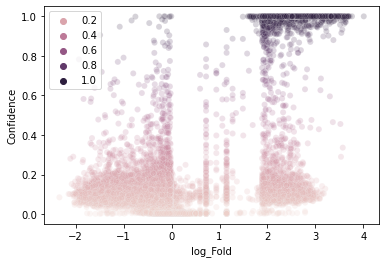

In [265]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train_orig, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [266]:
embedding=umap.embedding_classification(model,X_train)

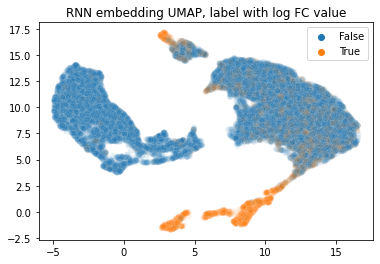

In [267]:
umap.UMAP_log_Fold(embedding, y_f_train)

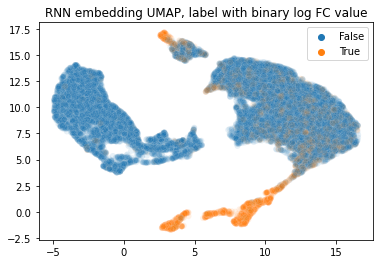

In [268]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

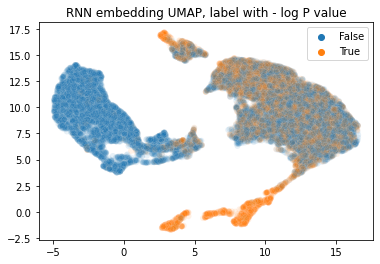

In [269]:
umap.UMAP_log_P(embedding, y_p_train)

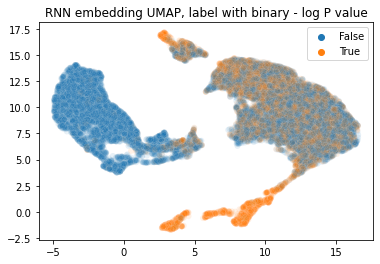

In [270]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

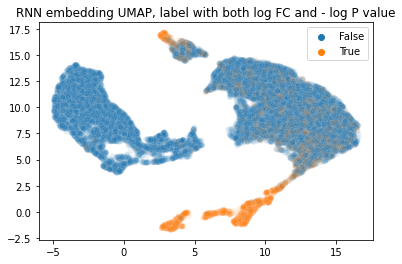

In [271]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [272]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [273]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if x2<5 :
            good_seqs.append(X_seq[i])

In [274]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [275]:
ninemer_seq

['LVLRYFAA',
 'ACGWKSCE',
 'SNGDYAAC',
 'GCLGVYAC',
 'CRATWGEE',
 'GCLGYYAC',
 'KCDYAAHC',
 'YCRGDYAF',
 'ACFGDSAC',
 'LCFVDYAC',
 'GWVGDYAC',
 'CNGDYAGC',
 'CRLYDGCD',
 'DDLLYYAA',
 'SDLADYAA',
 'TCCDYACW',
 'CWEYACWS',
 'CCEDLFDY',
 'KDLQDYAA',
 'CVGDYACR',
 'CGDYASYC',
 'CRGDYACR',
 'CWMTWWEE',
 'GCGDYAAR',
 'CWMPWCEV',
 'CYGDYACG',
 'CFGDYACA',
 'LDLGYYAA',
 'AWGDYAAC',
 'VVYYYSAA',
 'YDRPDYAA',
 'EDLRDFAA',
 'CGDYSACR',
 'CVWTLCEE',
 'CWMPWWEE',
 'RCSGDYAC',
 'YCFGDYVC',
 'CYGDYSAC',
 'GCMGDYAC',
 'NCRGDYAW',
 'KCWDYSCC',
 'CNDYNSLD',
 'RCLGDYSR',
 'ACNCYCLE',
 'DTGDYAAA',
 'TCVGDYAC',
 'CGDYSARW',
 'LCGGDYAC',
 'CGDYAACL',
 'YPDYVEAA',
 'DVLRVYAA',
 'WRWYDGCE',
 'VWGDYAAC',
 'CRGVYAAC',
 'EDLVDYAA',
 'SCVGDYAC',
 'CKGDYAWC',
 'CGDYAACS',
 'NCWGDYSC',
 'CFYDYACW',
 'CRAVDGCD',
 'EDLRGYAA',
 'VDLREYAA',
 'DRKDYSAA',
 'VVLGDFAA',
 'CAYTWCEE',
 'CLGDYAAW',
 'CFGDYACS',
 'YCADLYDY',
 'YDLRDYAA',
 'SCYGDFAC',
 'EDLRYFAA',
 'DVRDYAAA',
 'WCYGDYAC',
 'FCDGDYAC',
 'CGDYAACD',
 'CSYTWCEE',

In [276]:
import pandas as pd

In [277]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [278]:
seq9_s

1  2  3  4  5  6  7  8
0     L  V  L  R  Y  F  A  A
1     A  C  G  W  K  S  C  E
2     S  N  G  D  Y  A  A  C
3     G  C  L  G  V  Y  A  C
4     C  R  A  T  W  G  E  E
...  .. .. .. .. .. .. .. ..
1257  G  C  N  S  Y  C  Y  E
1258  D  D  L  G  D  Y  A  A
1259  K  C  F  G  D  S  A  C
1260  C  W  M  T  G  G  E  E
1261  A  D  K  A  D  Y  A  A

[1262 rows x 8 columns]

In [279]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [280]:
seq9_result

1    2    3    4    5      6      7    8
A   40   26   46   47   88  246.0  733.0  437
C  399  410   12   14    1  150.0  152.0  423
D   95  243  125  282  505   17.0   37.0   32
E  109    8    6    5   23   25.0  100.0  162
F   49   25  110   15   14   93.0    4.0   17
G   73   80  188  298   14   65.0   28.0   21
H   18    4   24    4    7   10.0    4.0    3
K   44    7   21    4    3    NaN    NaN    5
L   74   41  324   53   20    3.0   33.0    9
M   23   16   36   11    3    9.0   20.0    3
N   17   45   38    4    4    6.0    9.0    1
P   15   30   14   47    2    3.0    5.0    4
Q    9    6    8    5    2    4.0    3.0    3
R   58   87   53  148   24   26.0   13.0   33
S   29   42   19   40   42   86.0   54.0   13
T   25   11   10   66    4    8.0    NaN    2
V   92   84   69   50   25   21.0   31.0   16
W   13   42   57   19   65    9.0    9.0   47
Y   80   55  102  150  416  481.0   27.0   31

<AxesSubplot: >

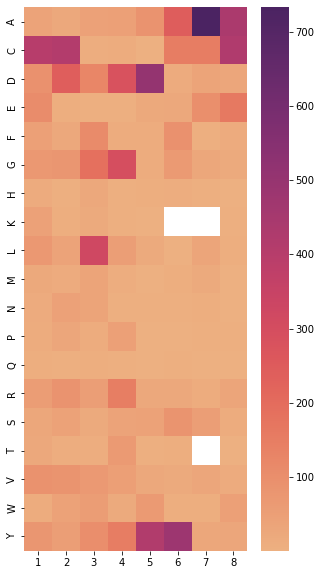

In [281]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [282]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

[('FAA', 88),
 ('PDY', 91),
 ('CLG', 97),
 ('ACG', 102),
 ('ACR', 104),
 ('DLR', 108),
 ('AAC', 111),
 ('CGD', 113),
 ('RDY', 116),
 ('LGD', 137),
 ('DYS', 160),
 ('YAC', 233),
 ('YAA', 349),
 ('GDY', 578),
 ('DYA', 703)]

In [283]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])

('DYA', 703)
('GDY', 578)
('YAA', 349)
('YAC', 233)
('DYS', 160)


## mCDH2 vs 12ca5

In [69]:
R3_lib = data_loading.read_data_and_preprocess(datafile="12ca5-MDM2-mCDH2-R3.csv")
protein_of_interest = "mCDH2"
other_protein = "12ca5"
X, y = data_loading.build_dataset(
    R3_lib,
    protein_of_interest=protein_of_interest,
    other_protein=other_protein,
    dataset_type=data_loading.DATASET_TYPE.JOINT_REGRESSION,
)

 - log P value cutoff is -0.33058129229327954, and log FC value cutoff is -0.955421147441985


In [70]:
y_f_cutoff =  -0.955421147441985
y_p_cutoff = -0.33058129229327954

y_orig = y.copy()
y[:,1]= y[:,1]>y_f_cutoff
y[:,0] = y[:,0]>y_p_cutoff

In [71]:
from sklearn import preprocessing
import pandas as pd

In [72]:
pep=[]
for feature in X:
    pep.append(RAA_to_seq(feature[:,1]))

In [73]:
aa_store = []
for peptide in R3_lib.Peptide.values:
    aa_store += list(peptide)
amino_acids=list(set(aa_store))

In [74]:
enc = preprocessing.LabelBinarizer().fit(amino_acids)

In [75]:
MAX_PEPTIDE_LEN=280
def one_hot(seq):
    vec = np.zeros(MAX_PEPTIDE_LEN)
    features = seq
    vec[: len(seq)] = features
    return vec

In [76]:
X = [one_hot(np.ravel([[enc.transform([amino_acid])] for amino_acid in peptide])) for peptide in pep]

In [77]:
from sklearn.decomposition import PCA

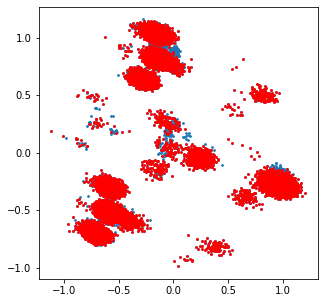

In [78]:
pca = PCA(n_components=100)
crds = pca.fit_transform(X)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(crds[:,0], crds[:,1], s=3, label='inactive') 
ax.scatter(crds[y[:,1] == 1][:, 0], 
            crds[y[:,1] == 1][:, 1], color='red', s= 3, label='active')

In [79]:
print("The first 100 components explains {} of the total variance".format(pca.explained_variance_ratio_.sum() ))

The first 100 components explains 0.8445470401830149 of the total variance


In [80]:
from sklearn.manifold import TSNE

/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/choyl/opt/anaconda3/envs/NGS_project/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization

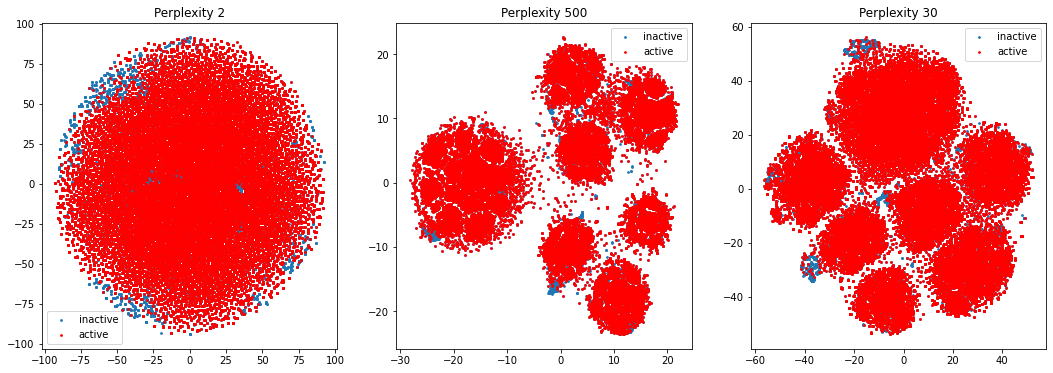

In [81]:
perplexities = [2, 500, 30]

fig, ax = plt.subplots(figsize=(18, 6), ncols=3)

for i, perplexity in enumerate(perplexities):
    pca_tsne = TSNE(n_components=2, perplexity=perplexity).fit_transform(crds)

    ax[i].scatter(pca_tsne[:,0], pca_tsne[:,1], s=3, label='inactive') 
    ax[i].scatter(pca_tsne[y[:,1] == 1][:, 0], 
                pca_tsne[y[:,1] == 1][:, 1], color='red', s= 3, label='active')


    ax[i].legend()
    ax[i].set_title(f'Perplexity {perplexity}')

In [82]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [83]:
df = pd.DataFrame(list(zip(pep, X, y[:,1], y[:,0])),columns =['Peptide', 'one-hot', 'log_Fold', '-log_P_value'])

In [84]:
kf = KFold(n_splits=10, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, y_train = np.array(X)[train_index], y[:,1][train_index]
    
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)
    
    X_test = np.array(X)[test_index]
    
    # Append test 
    pred = rf.predict(X_test) 
    
    for i, index in enumerate(test_index):
        df.loc[index, 'pred_class'] = pred[i]

In [85]:
for index, row in df.iterrows():
    
    if row.log_Fold == 1:
        if row.pred_class == 1:
        
            label = 'TruePositive'
        else:
            label = 'FalseNegative'
            
    if row.log_Fold == 0:
        if row.pred_class == 1:       
            label = 'FalsePositve'
        else:
            label = 'TrueNegative'
            
    
    df.loc[index, 'label'] = label

In [86]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

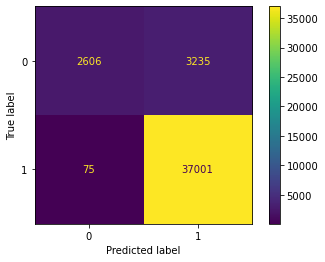

In [87]:
cm = confusion_matrix(df.log_Fold, df.pred_class )
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

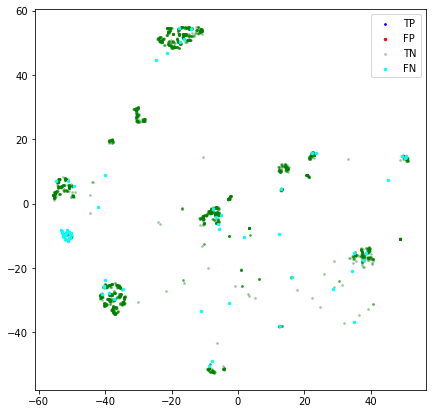

In [88]:
fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(pca_tsne[df.label == 'TruePostive'][:, 0], pca_tsne[df.label == 'TruePostive'][:, 1], color='blue', s= 3, label='TP')
ax.scatter(pca_tsne[df.label == 'FalsePostive'][:, 0], pca_tsne[df.label == 'FalsePostive'][:, 1], color='red', s= 6, label='FP')
ax.scatter(pca_tsne[df.label == 'TrueNegative'][:, 0], pca_tsne[df.label == 'TrueNegative'][:, 1], color='green', s= 3, label='TN', alpha=0.3)
ax.scatter(pca_tsne[df.label == 'FalseNegative'][:, 0], pca_tsne[df.label == 'FalseNegative'][:, 1], color='cyan', s= 6, label='FN')

ax.legend()

In [89]:
tn, fp, fn, tp = cm = confusion_matrix(df.log_Fold, df.pred_class).ravel()
acc, pre, rec = [], [], []
print(tn, fp, fn, tp)
print("accuracy", (tn+tp)/(tn+fp+fn+tp))
acc.append((tn+tp)/(tn+fp+fn+tp))
print("precision", tp/(tp+fp))
pre.append(tp/(tp+fp))
print("recall", tp/(tp+fn))
rec.append(tp/(tp+fn))

2606 3235 75 37001
accuracy 0.9228743854416664
precision 0.9195993637538523
recall 0.9979771280612796


In [300]:
TP_sequence = np.array(df[df.label == 'TruePositive']['Peptide'])

In [301]:
sum(df.label == 'TruePositive')

37004

In [302]:
ninemer_TPseq = []
for seq in TP_sequence:
    if len(seq)== 9:
        ninemer_TPseq.append(seq[1:])

In [303]:
seq9_s = pd.Series(ninemer_TPseq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [304]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

<AxesSubplot: >

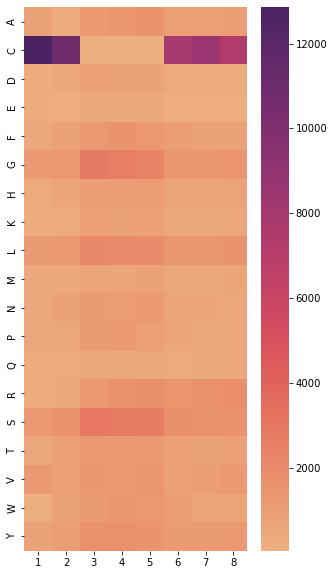

In [305]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [306]:
X = np.array(np.array([item.reshape(14,20) for item in X]).tolist())

In [307]:
result = experiment.BinaryClassificationExperiment().run_adhoc_experiment(
    X, y, rnn.Joint_BinaryClassificationRNN_gelu
)

Epoch 1/50
269/269 [==============================] - 6s 7ms/step - loss: 0.4873 - accuracy: 0.6662 - recall_6: 0.7348 - precision_6: 0.8551
Epoch 2/50
269/269 [==============================] - 2s 7ms/step - loss: 0.4211 - accuracy: 0.6921 - recall_6: 0.7575 - precision_6: 0.8743
Epoch 3/50
269/269 [==============================] - 2s 6ms/step - loss: 0.4106 - accuracy: 0.6959 - recall_6: 0.7559 - precision_6: 0.8875
Epoch 4/50
269/269 [==============================] - 2s 6ms/step - loss: 0.4022 - accuracy: 0.6990 - recall_6: 0.7572 - precision_6: 0.8932
Epoch 5/50
269/269 [==============================] - 2s 7ms/step - loss: 0.3941 - accuracy: 0.7015 - recall_6: 0.7578 - precision_6: 0.8961
Epoch 6/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3898 - accuracy: 0.7036 - recall_6: 0.7586 - precision_6: 0.8991
Epoch 7/50
269/269 [==============================] - 2s 6ms/step - loss: 0.3872 - accuracy: 0.7038 - recall_6: 0.7588 - precision_6: 0.9003
Epoch 8/50
26

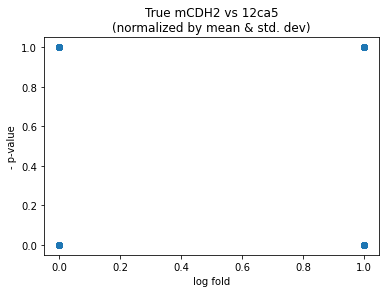

In [308]:
import matplotlib.pyplot as plt

def show_volcano(y, protein_of_interest, other_protein, title_addendum=""):
    plt.title(
        title_addendum
        + protein_of_interest
        + " vs "
        + other_protein
        + "\n(normalized by mean & std. dev)"
    )
    plt.ylabel("- p-value")
    plt.xlabel("log fold")
    plt.scatter(y[:, 1], y[:, 0], alpha=0.2)
    plt.show()

show_volcano(
    y, protein_of_interest, other_protein, title_addendum="True "
)

In [309]:
model =result.trained_model

In [310]:
X_train, X_test, y_f_train, y_f_test, y_p_train, y_p_test = scatter_plots.Kfold_sample(5, 0, X, y_orig)

In [311]:
y_f_train_orig = y_f_train.copy()
y_p_train_orig = y_p_train.copy()
y_f_test_orig = y_f_test.copy()
y_p_test_orig = y_p_test.copy()

y_f_train= y_f_train>y_f_cutoff
y_p_train = y_p_train>y_p_cutoff
y_f_test= y_f_test>y_f_cutoff
y_p_test = y_p_test>y_p_cutoff

In [312]:
# evaluate accuracy, precision, recall of trianed model
evaluation.classifcation_evaluation(y_f_train, model(X_train)[:,1],y_f_cutoff)

0 0 2137 32196
accuracy 0.9377566772492937
precision 1.0
recall 0.9377566772492937


Text(0.5, 0, 'log_Fold')

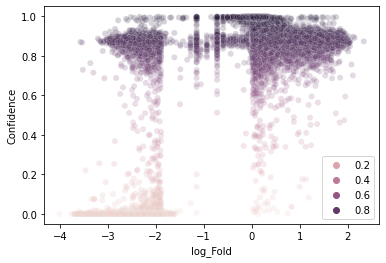

In [313]:
# confidence analysis
ax = sns.scatterplot(x=y_f_train_orig, y=model(X_train)[:,1].numpy().reshape(-1), hue=model(X_train)[:,1].numpy().reshape(-1), alpha=0.2)
ax.set_ylabel('Confidence')
ax.set_xlabel('log_Fold')

In [314]:
embedding=umap.embedding_classification(model,X_train)

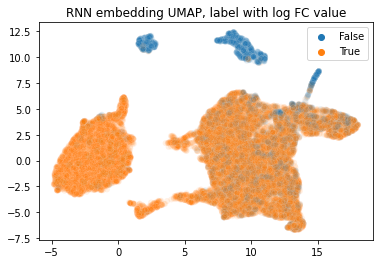

In [315]:
umap.UMAP_log_Fold(embedding, y_f_train)

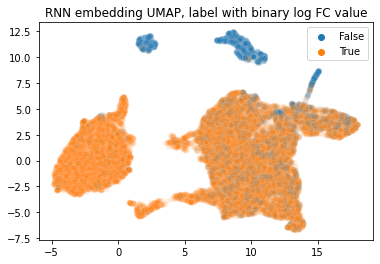

In [316]:
umap.UMAP_binary_log_Fold(embedding, y_f_train,0.5)

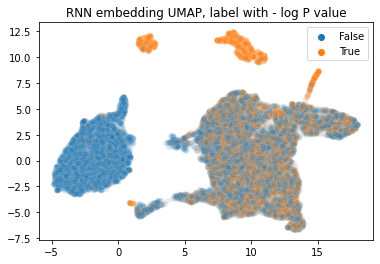

In [317]:
umap.UMAP_log_P(embedding, y_p_train)

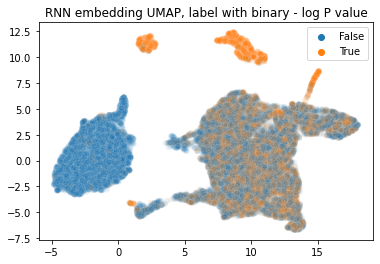

In [334]:
umap.UMAP_binary_log_P(embedding, y_p_train, 0.5)

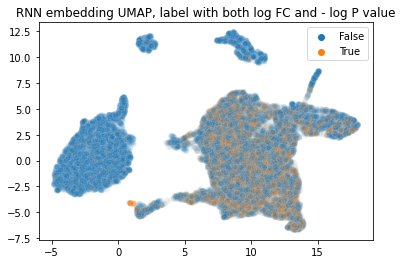

In [329]:
umap.UMAP_joint(embedding, y_f_train, 0.5, y_p_train, 0.5)

In [320]:
X_seq = np.array([enc.inverse_transform(peptide) for peptide in X_train])
X_seq = [one_peptide[idx_bool] for one_peptide, idx_bool in zip(X_seq, X.sum(axis=2)>0)]
X_seq = [''.join(peptide_array) for peptide_array in X_seq]

In [321]:
good_seqs= []
for i in range(len(embedding)):
    x1 = embedding[i][0]
    x2 = embedding[i][1]
    if y_f_train[i] > 0.5:
        if x2<5 :
            good_seqs.append(X_seq[i])

In [274]:
ninemer_seq = []
for seq in good_seqs:
    if len(seq) == 9:
        ninemer_seq.append(seq[1:])

In [275]:
ninemer_seq

['LVLRYFAA',
 'ACGWKSCE',
 'SNGDYAAC',
 'GCLGVYAC',
 'CRATWGEE',
 'GCLGYYAC',
 'KCDYAAHC',
 'YCRGDYAF',
 'ACFGDSAC',
 'LCFVDYAC',
 'GWVGDYAC',
 'CNGDYAGC',
 'CRLYDGCD',
 'DDLLYYAA',
 'SDLADYAA',
 'TCCDYACW',
 'CWEYACWS',
 'CCEDLFDY',
 'KDLQDYAA',
 'CVGDYACR',
 'CGDYASYC',
 'CRGDYACR',
 'CWMTWWEE',
 'GCGDYAAR',
 'CWMPWCEV',
 'CYGDYACG',
 'CFGDYACA',
 'LDLGYYAA',
 'AWGDYAAC',
 'VVYYYSAA',
 'YDRPDYAA',
 'EDLRDFAA',
 'CGDYSACR',
 'CVWTLCEE',
 'CWMPWWEE',
 'RCSGDYAC',
 'YCFGDYVC',
 'CYGDYSAC',
 'GCMGDYAC',
 'NCRGDYAW',
 'KCWDYSCC',
 'CNDYNSLD',
 'RCLGDYSR',
 'ACNCYCLE',
 'DTGDYAAA',
 'TCVGDYAC',
 'CGDYSARW',
 'LCGGDYAC',
 'CGDYAACL',
 'YPDYVEAA',
 'DVLRVYAA',
 'WRWYDGCE',
 'VWGDYAAC',
 'CRGVYAAC',
 'EDLVDYAA',
 'SCVGDYAC',
 'CKGDYAWC',
 'CGDYAACS',
 'NCWGDYSC',
 'CFYDYACW',
 'CRAVDGCD',
 'EDLRGYAA',
 'VDLREYAA',
 'DRKDYSAA',
 'VVLGDFAA',
 'CAYTWCEE',
 'CLGDYAAW',
 'CFGDYACS',
 'YCADLYDY',
 'YDLRDYAA',
 'SCYGDFAC',
 'EDLRYFAA',
 'DVRDYAAA',
 'WCYGDYAC',
 'FCDGDYAC',
 'CGDYAACD',
 'CSYTWCEE',

In [276]:
import pandas as pd

In [277]:
seq9_s = pd.Series(ninemer_seq)
seq9_s=seq9_s.str.split(r'', expand=True)
seq9_s = seq9_s.drop(0,axis=1)
seq9_s = seq9_s.drop(9,axis=1)

In [278]:
seq9_s

1  2  3  4  5  6  7  8
0     L  V  L  R  Y  F  A  A
1     A  C  G  W  K  S  C  E
2     S  N  G  D  Y  A  A  C
3     G  C  L  G  V  Y  A  C
4     C  R  A  T  W  G  E  E
...  .. .. .. .. .. .. .. ..
1257  G  C  N  S  Y  C  Y  E
1258  D  D  L  G  D  Y  A  A
1259  K  C  F  G  D  S  A  C
1260  C  W  M  T  G  G  E  E
1261  A  D  K  A  D  Y  A  A

[1262 rows x 8 columns]

In [279]:
frames=[]
for i in range(8):
    frames.append(seq9_s.iloc[:,i].value_counts().sort_index())
seq9_result = pd.concat(frames,axis=1,join='outer')

In [280]:
seq9_result

1    2    3    4    5      6      7    8
A   40   26   46   47   88  246.0  733.0  437
C  399  410   12   14    1  150.0  152.0  423
D   95  243  125  282  505   17.0   37.0   32
E  109    8    6    5   23   25.0  100.0  162
F   49   25  110   15   14   93.0    4.0   17
G   73   80  188  298   14   65.0   28.0   21
H   18    4   24    4    7   10.0    4.0    3
K   44    7   21    4    3    NaN    NaN    5
L   74   41  324   53   20    3.0   33.0    9
M   23   16   36   11    3    9.0   20.0    3
N   17   45   38    4    4    6.0    9.0    1
P   15   30   14   47    2    3.0    5.0    4
Q    9    6    8    5    2    4.0    3.0    3
R   58   87   53  148   24   26.0   13.0   33
S   29   42   19   40   42   86.0   54.0   13
T   25   11   10   66    4    8.0    NaN    2
V   92   84   69   50   25   21.0   31.0   16
W   13   42   57   19   65    9.0    9.0   47
Y   80   55  102  150  416  481.0   27.0   31

<AxesSubplot: >

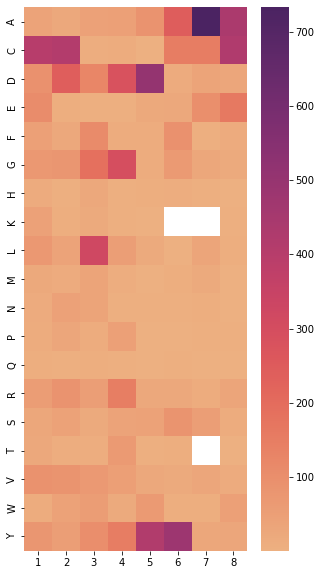

In [281]:
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(seq9_result, cmap=sns.color_palette("flare", as_cmap=True))

In [ ]:
Dict_3mer_occ = {}
for tmer in initialize_Proc2Vec_embeddings().keys():
    tmer_good_seqs = [find_3mer(seq, tmer) for seq in good_seqs]
    tmer_occ = np.array(tmer_good_seqs).sum()
    Dict_3mer_occ[tmer] = tmer_occ

sorted_x = sorted(Dict_3mer_occ.items(), key=operator.itemgetter(1))
sorted_x[-15:]

[('AAA', array([-1.74060e-01, -9.57560e-02,  5.95150e-02,  3.96730e-02,
       -3.75934e-01, -1.15415e-01,  9.07250e-02,  1.73422e-01,
        2.92520e-01,  1.90375e-01,  9.40910e-02, -1.97482e-01,
       -1.35202e-01,  7.55210e-02,  1.10771e-01,  4.79090e-02,
       -3.91934e-01,  7.35480e-02,  1.03868e-01, -4.59240e-02,
       -9.53400e-03,  5.56590e-02, -3.08000e-04,  2.15941e-01,
        8.44760e-02,  6.15730e-02,  1.28139e-01,  1.84247e-01,
       -1.00091e-01, -1.26661e-01, -5.72800e-03, -3.82720e-02,
        1.80597e-01, -1.55310e-01,  5.62320e-02, -5.92500e-03,
       -8.53810e-02, -5.69210e-02, -4.55200e-02,  2.65116e-01,
        9.02210e-02, -2.09879e-01,  2.05381e-01,  2.36790e-02,
       -9.29390e-02,  7.27670e-02, -1.05107e-01,  1.11120e-02,
       -1.60518e-01,  4.26270e-02,  1.51230e-01, -1.62708e-01,
       -8.34790e-02, -1.46657e-01,  9.13320e-02,  1.09579e-01,
       -1.01678e-01,  9.11980e-02,  5.51200e-03,  4.73180e-02,
        7.81080e-02,  2.03824e-01, -1.00126e-0

In [ ]:
print(sorted_x[-1])
print(sorted_x[-2])
print(sorted_x[-3])
print(sorted_x[-4])
print(sorted_x[-5])